# CitiBike NYC: Urban Mobility Analysis
### Exploratory Data Analysis of 5+ Million Bike-Share Trips

**Author:** Miguel Ángel Vázquez Varela  
**Date:** October 2025  
**Dataset:** September 2025 CitiBike Trip Data

---

## Executive Summary

This analysis explores over 5 million bike trips from NYC's CitiBike system to uncover:
- **Usage patterns** by time of day, day of week, and user type
- **Trip characteristics** including duration distributions and popular routes
- **Station dynamics** identifying high-demand locations and rebalancing needs
- **Business insights** for operational optimization and marketing strategies

---
## 1. Setup and Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import requests
from io import BytesIO
import warnings
warnings.filterwarnings('ignore')

# Set professional visualization style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 100

# Custom color palettes
COLORS = {
    'primary': '#1f77b4',
    'secondary': '#ff7f0e', 
    'member': '#2ecc71',
    'casual': '#e74c3c',
    'highlight': '#9b59b6',
    'neutral': '#7f8c8d'
}

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# Download and merge data from CitiBike S3
url = "https://s3.amazonaws.com/tripdata/202509-citibike-tripdata.zip"
print("Downloading data from CitiBike S3...")
print(f"Source: {url}\n")

r = requests.get(url)
z = zipfile.ZipFile(BytesIO(r.content))

print(f"Files in ZIP archive:")
for f in z.namelist():
    print(f"  - {f}")

# Merge all CSV files into single DataFrame
dfs = []
for f in z.namelist():
    df_part = pd.read_csv(z.open(f), parse_dates=['started_at', 'ended_at'], low_memory=False)
    dfs.append(df_part)
    print(f"Loaded {f}: {len(df_part):,} records")

df = pd.concat(dfs, ignore_index=True)
print(f"\n{'='*50}")
print(f"TOTAL RECORDS LOADED: {len(df):,}")
print(f"{'='*50}")

Source: https://s3.amazonaws.com/tripdata/202509-citibike-tripdata.zip

Files in ZIP archive:
  - 202509-citibike-tripdata_3.csv
  - 202509-citibike-tripdata_2.csv
  - 202509-citibike-tripdata_1.csv
  - 202509-citibike-tripdata_5.csv
  - 202509-citibike-tripdata_4.csv
  - 202509-citibike-tripdata_6.csv
Loaded 202509-citibike-tripdata_3.csv: 1,000,000 records
Loaded 202509-citibike-tripdata_2.csv: 1,000,000 records
Loaded 202509-citibike-tripdata_1.csv: 1,000,000 records
Loaded 202509-citibike-tripdata_5.csv: 1,000,000 records
Loaded 202509-citibike-tripdata_4.csv: 1,000,000 records
Loaded 202509-citibike-tripdata_6.csv: 287,447 records

TOTAL RECORDS LOADED: 5,287,447


---
## 2. Data Overview & Quality Assessment

In [3]:
# Dataset structure
print("DATASET STRUCTURE")
print("="*50)
print(f"Rows: {df.shape[0]:,}")
print(f"Columns: {df.shape[1]}")
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
print(f"\nDate Range: {df['started_at'].min().date()} to {df['started_at'].max().date()}")
print("\n" + "="*50)
print("COLUMN DETAILS")
print("="*50)
df.info()

DATASET STRUCTURE
Rows: 5,287,447
Columns: 13

Memory Usage: 2418.4 MB

Date Range: 2025-08-30 to 2025-09-30

COLUMN DETAILS
<class 'pandas.DataFrame'>
RangeIndex: 5287447 entries, 0 to 5287446
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             str           
 1   rideable_type       str           
 2   started_at          datetime64[us]
 3   ended_at            datetime64[us]
 4   start_station_name  str           
 5   start_station_id    str           
 6   end_station_name    str           
 7   end_station_id      str           
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       str           
dtypes: datetime64[us](2), float64(4), str(7)
memory usage: 524.4 MB


In [4]:
# Sample data preview
print("DATA SAMPLE (First 5 rows)")
df.head()

DATA SAMPLE (First 5 rows)


,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,3B0C318A532F94B6,electric_bike,2025-09-03 12:44:03.601,2025-09-03 12:59:16.021,W 13 St & 5 Ave,5947.04,E 54 St & 1 Ave,6608.09,40.735445,-73.994310,40.756265,-73.964179,member
1,67CC23751CDE251A,classic_bike,2025-09-14 09:18:47.498,2025-09-14 09:33:03.258,Lexington Ave & E 36 St,6313.10,E 54 St & 1 Ave,6608.09,40.747574,-73.978801,40.756265,-73.964179,member
2,2D021D09674010AF,electric_bike,2025-09-06 08:17:40.035,2025-09-06 08:25:41.230,Willoughby Ave & Hall St,4611.03,Park Pl & Carlton Ave,4125.13,40.691960,-73.965369,40.677358,-73.972110,member
3,4641BFF9A21AFB34,electric_bike,2025-09-04 04:30:51.715,2025-09-04 04:44:51.147,Lexington Ave & E 36 St,6313.10,W 12 St & Hudson St,5997.10,40.747574,-73.978801,40.737530,-74.005589,member
4,D796A741FA3963FF,classic_bike,2025-09-06 14:32:16.249,2025-09-06 14:35:42.124,W 13 St & 5 Ave,5947.04,W 15 St & 6 Ave,5989.02,40.735445,-73.994310,40.738046,-73.996430,member


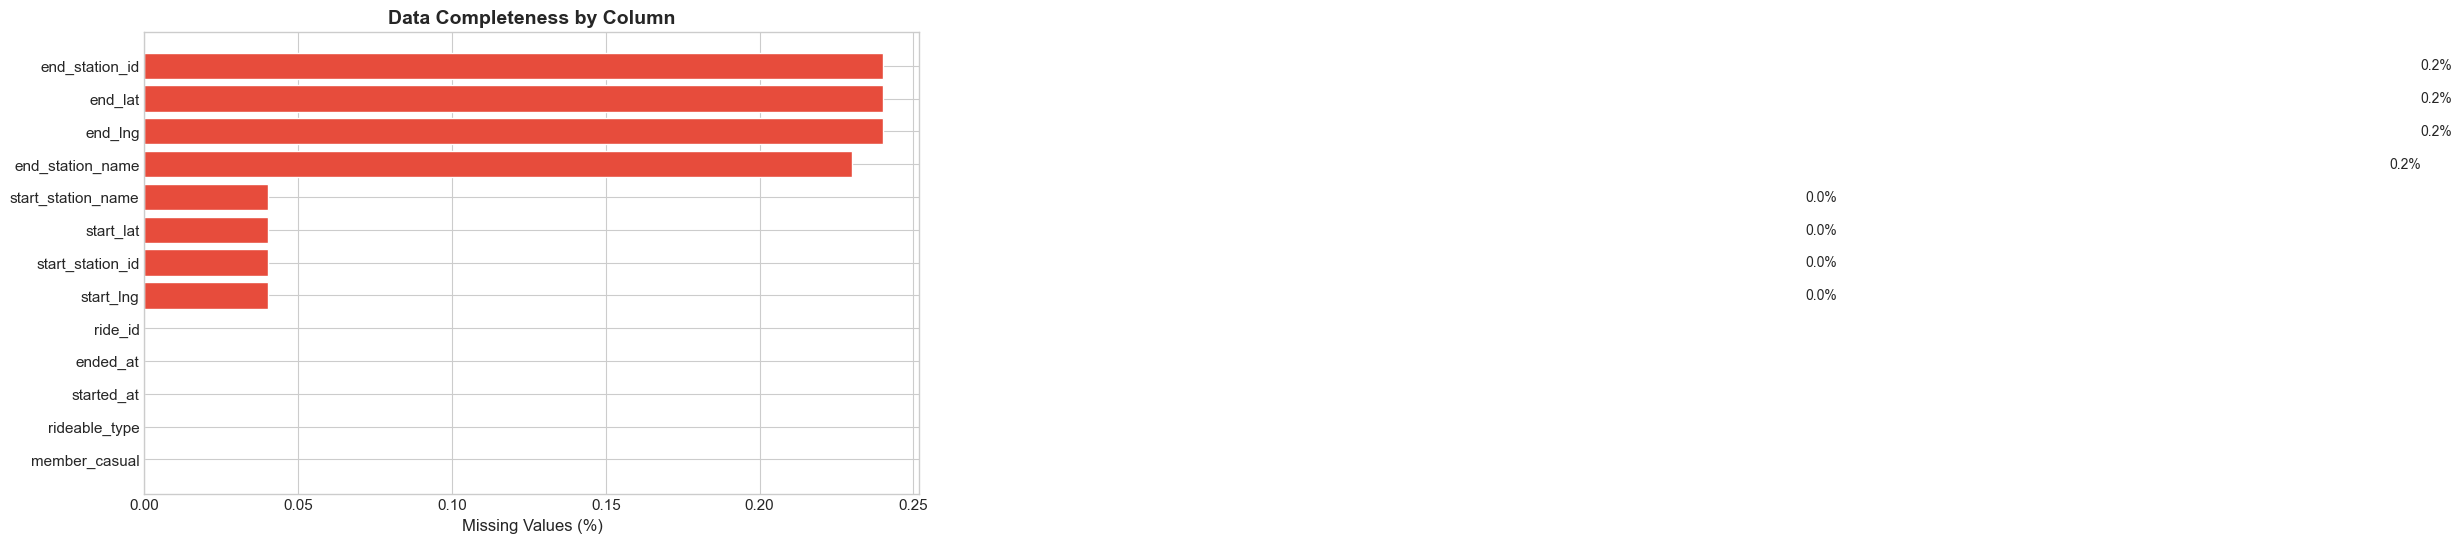


MISSING VALUES SUMMARY
            Column  Missing Count  Missing %
    end_station_id          12949       0.24
           end_lat          12937       0.24
           end_lng          12937       0.24
  end_station_name          12266       0.23
start_station_name           2118       0.04
         start_lat           2118       0.04
  start_station_id           2118       0.04
         start_lng           2118       0.04


In [5]:
# Missing values analysis with visualization
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
}).sort_values('Missing Count', ascending=False)

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in missing_df['Missing %']]
bars = ax.barh(missing_df['Column'], missing_df['Missing %'], color=colors, edgecolor='white')
ax.set_xlabel('Missing Values (%)')
ax.set_title('Data Completeness by Column')
ax.invert_yaxis()

# Add percentage labels
for bar, pct in zip(bars, missing_df['Missing %']):
    if pct > 0:
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\nMISSING VALUES SUMMARY")
print(missing_df[missing_df['Missing Count'] > 0].to_string(index=False))

---
## 3. Feature Engineering

In [6]:
# Calculate trip duration
df['duration_min'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

# Data quality: Filter invalid trips
original_size = len(df)
df = df[(df['duration_min'] > 0) & (df['duration_min'] <= 180)]
removed = original_size - len(df)

print(f"DATA CLEANING")
print(f"="*50)
print(f"Original records: {original_size:,}")
print(f"Records removed (invalid duration): {removed:,} ({removed/original_size*100:.2f}%)")
print(f"Clean dataset size: {len(df):,}")

# Extract temporal features
df['hour'] = df['started_at'].dt.hour
df['day_of_week'] = df['started_at'].dt.day_name()
df['day_num'] = df['started_at'].dt.dayofweek
df['date'] = df['started_at'].dt.date
df['is_weekend'] = df['day_num'].isin([5, 6])
df['week'] = df['started_at'].dt.isocalendar().week
df['time_period'] = pd.cut(df['hour'], 
                           bins=[0, 6, 10, 16, 20, 24], 
                           labels=['Night (0-6)', 'Morning Rush (6-10)', 
                                   'Midday (10-16)', 'Evening Rush (16-20)', 'Night (20-24)'],
                           include_lowest=True)

print(f"\nNew features created: duration_min, hour, day_of_week, is_weekend, time_period")

DATA CLEANING
Original records: 5,287,447
Records removed (invalid duration): 5,526 (0.10%)
Clean dataset size: 5,281,921

New features created: duration_min, hour, day_of_week, is_weekend, time_period


---
## 4. Trip Duration Analysis

Understanding trip duration is fundamental for:
- **Pricing optimization**: Duration-based pricing tiers
- **Fleet management**: Predicting bike availability
- **User experience**: Identifying potential issues (too short = dock problems, too long = lost bikes)

In [7]:
# Duration statistics
print("TRIP DURATION STATISTICS")
print("="*50)
stats = df['duration_min'].describe(percentiles=[.25, .5, .75, .90, .95, .99])
print(f"Mean:     {stats['mean']:.1f} minutes")
print(f"Median:   {stats['50%']:.1f} minutes")
print(f"Std Dev:  {stats['std']:.1f} minutes")
print(f"\nPercentiles:")
print(f"  25th:   {stats['25%']:.1f} min")
print(f"  75th:   {stats['75%']:.1f} min")
print(f"  90th:   {stats['90%']:.1f} min")
print(f"  95th:   {stats['95%']:.1f} min")
print(f"  99th:   {stats['99%']:.1f} min")

TRIP DURATION STATISTICS
Mean:     12.9 minutes
Median:   9.6 minutes
Std Dev:  11.6 minutes

Percentiles:
  25th:   5.6 min
  75th:   16.4 min
  90th:   25.8 min
  95th:   33.5 min
  99th:   56.1 min


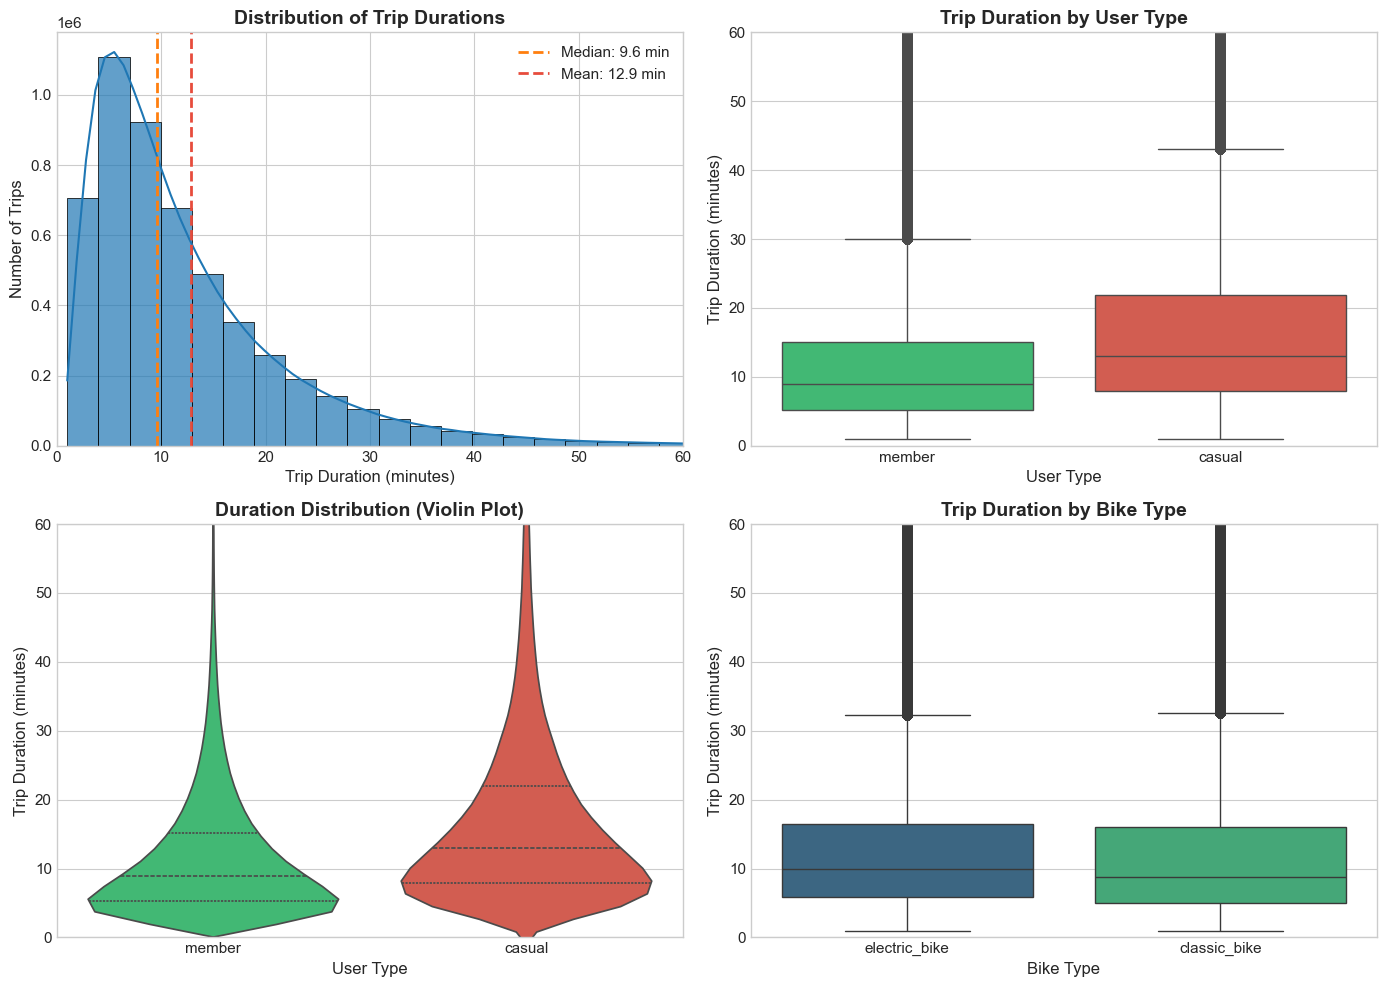

In [8]:
# Duration distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram with KDE
ax1 = axes[0, 0]
sns.histplot(df['duration_min'], bins=60, kde=True, ax=ax1, color=COLORS['primary'], alpha=0.7)
ax1.axvline(df['duration_min'].median(), color=COLORS['secondary'], linestyle='--', linewidth=2, 
            label=f'Median: {df["duration_min"].median():.1f} min')
ax1.axvline(df['duration_min'].mean(), color=COLORS['casual'], linestyle='--', linewidth=2, 
            label=f'Mean: {df["duration_min"].mean():.1f} min')
ax1.set_xlim(0, 60)
ax1.set_xlabel('Trip Duration (minutes)')
ax1.set_ylabel('Number of Trips')
ax1.set_title('Distribution of Trip Durations')
ax1.legend()

# 2. Box plot by user type
ax2 = axes[0, 1]
sns.boxplot(data=df, x='member_casual', y='duration_min', ax=ax2, 
            palette=[COLORS['member'], COLORS['casual']])
ax2.set_ylim(0, 60)
ax2.set_xlabel('User Type')
ax2.set_ylabel('Trip Duration (minutes)')
ax2.set_title('Trip Duration by User Type')

# 3. Violin plot by user type (more detail)
ax3 = axes[1, 0]
sns.violinplot(data=df, x='member_casual', y='duration_min', ax=ax3,
               palette=[COLORS['member'], COLORS['casual']], inner='quartile')
ax3.set_ylim(0, 60)
ax3.set_xlabel('User Type')
ax3.set_ylabel('Trip Duration (minutes)')
ax3.set_title('Duration Distribution (Violin Plot)')

# 4. Duration by bike type
ax4 = axes[1, 1]
sns.boxplot(data=df, x='rideable_type', y='duration_min', ax=ax4,
            palette='viridis')
ax4.set_ylim(0, 60)
ax4.set_xlabel('Bike Type')
ax4.set_ylabel('Trip Duration (minutes)')
ax4.set_title('Trip Duration by Bike Type')

plt.tight_layout()
plt.show()

In [9]:
# Detailed statistics by user type
duration_stats = df.groupby('member_casual')['duration_min'].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).round(2)
duration_stats.columns = ['Total Trips', 'Mean (min)', 'Median (min)', 'Std Dev', 'Min', 'Max']
duration_stats['Total Trips'] = duration_stats['Total Trips'].apply(lambda x: f"{int(x):,}")

print("DURATION BY USER TYPE")
print("="*70)
print(duration_stats.to_string())
print("\n" + "="*70)
print("INSIGHT: Casual users take 40% longer trips on average than members,")
print("suggesting recreational vs. commuter usage patterns.")

DURATION BY USER TYPE
              Total Trips  Mean (min)  Median (min)  Std Dev  Min     Max
member_casual                                                            
casual            997,833       17.78         13.05    16.40  1.0  179.97
member          4,284,088       11.75          8.92     9.86  1.0  179.91

INSIGHT: Casual users take 40% longer trips on average than members,
suggesting recreational vs. commuter usage patterns.


---
## 5. Temporal Patterns

Analyzing **when** trips occur reveals:
- Commuter vs. leisure patterns
- Peak demand periods for resource allocation
- Opportunities for dynamic pricing

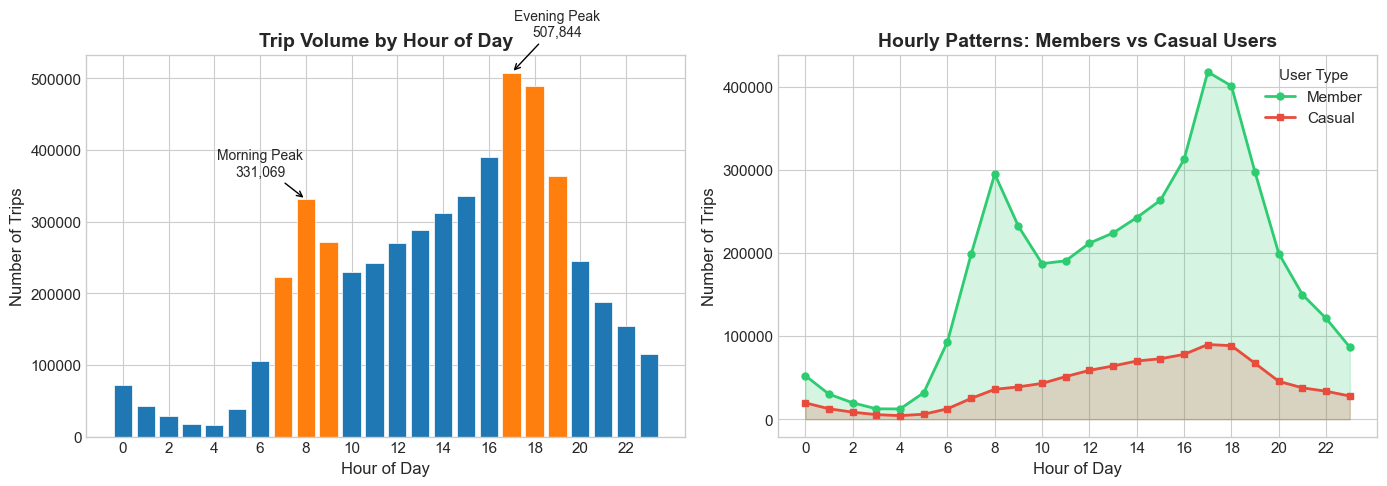

INSIGHT: Members show clear commuter patterns (8AM and 5-6PM peaks).
Casual users have a flatter distribution with midday preference.


In [10]:
# Hourly patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall hourly distribution
ax1 = axes[0]
hourly = df.groupby('hour').size()
colors = ['#ff7f0e' if h in [7, 8, 9, 17, 18, 19] else '#1f77b4' for h in hourly.index]
bars = ax1.bar(hourly.index, hourly.values, color=colors, edgecolor='white', linewidth=0.5)
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Number of Trips')
ax1.set_title('Trip Volume by Hour of Day')
ax1.set_xticks(range(0, 24, 2))

# Add peak annotations
morning_peak = hourly.loc[7:9].idxmax()
evening_peak = hourly.loc[17:19].idxmax()
ax1.annotate(f'Morning Peak\n{hourly[morning_peak]:,}', 
             xy=(morning_peak, hourly[morning_peak]), 
             xytext=(morning_peak-2, hourly[morning_peak]*1.1),
             fontsize=10, ha='center',
             arrowprops=dict(arrowstyle='->', color='black'))
ax1.annotate(f'Evening Peak\n{hourly[evening_peak]:,}', 
             xy=(evening_peak, hourly[evening_peak]), 
             xytext=(evening_peak+2, hourly[evening_peak]*1.1),
             fontsize=10, ha='center',
             arrowprops=dict(arrowstyle='->', color='black'))

# By user type
ax2 = axes[1]
hourly_user = df.groupby(['hour', 'member_casual']).size().unstack()
hourly_user['member'].plot(ax=ax2, marker='o', linewidth=2, markersize=5, 
                           color=COLORS['member'], label='Member')
hourly_user['casual'].plot(ax=ax2, marker='s', linewidth=2, markersize=5, 
                           color=COLORS['casual'], label='Casual')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Number of Trips')
ax2.set_title('Hourly Patterns: Members vs Casual Users')
ax2.set_xticks(range(0, 24, 2))
ax2.legend(title='User Type')
ax2.fill_between(hourly_user.index, 0, hourly_user['member'], alpha=0.2, color=COLORS['member'])
ax2.fill_between(hourly_user.index, 0, hourly_user['casual'], alpha=0.2, color=COLORS['casual'])

plt.tight_layout()
plt.show()

print("INSIGHT: Members show clear commuter patterns (8AM and 5-6PM peaks).")
print("Casual users have a flatter distribution with midday preference.")

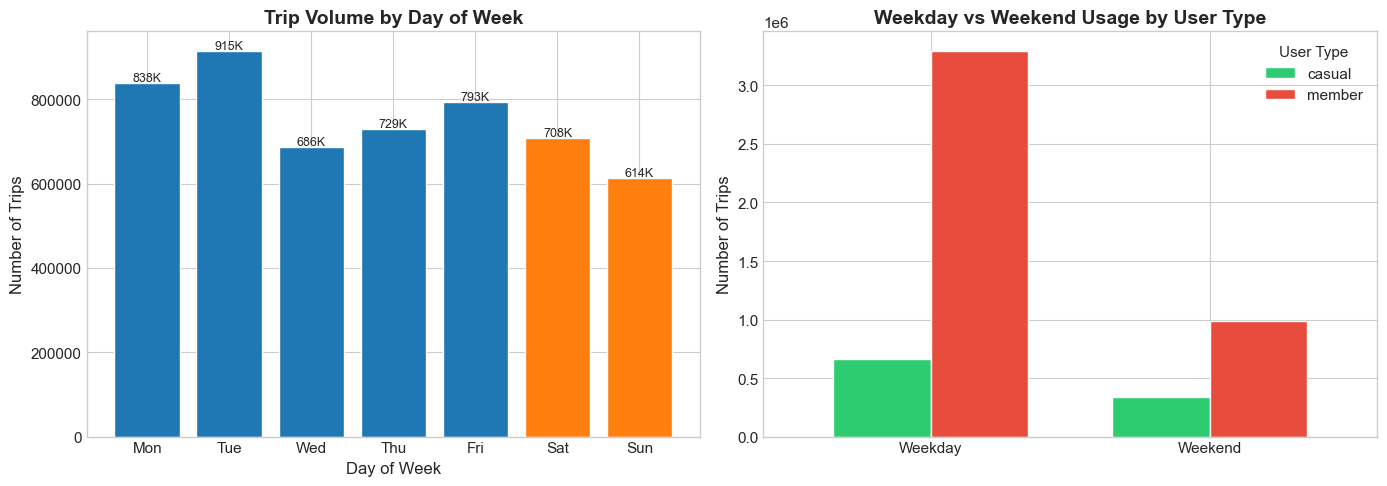

In [11]:
# Weekly patterns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily = df.groupby('day_of_week').size().reindex(day_order)

# Daily volume
ax1 = axes[0]
colors = [COLORS['primary'] if day not in ['Saturday', 'Sunday'] else COLORS['secondary'] for day in day_order]
bars = ax1.bar(range(7), daily.values, color=colors, edgecolor='white')
ax1.set_xticks(range(7))
ax1.set_xticklabels([d[:3] for d in day_order])
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Number of Trips')
ax1.set_title('Trip Volume by Day of Week')

# Add value labels
for bar, val in zip(bars, daily.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000, 
             f'{val/1000:.0f}K', ha='center', fontsize=9)

# Weekday vs Weekend by user type
ax2 = axes[1]
weekend_user = df.groupby(['is_weekend', 'member_casual']).size().unstack()
weekend_user.index = ['Weekday', 'Weekend']
weekend_user.plot(kind='bar', ax=ax2, color=[COLORS['member'], COLORS['casual']], 
                  edgecolor='white', width=0.7)
ax2.set_xlabel('')
ax2.set_ylabel('Number of Trips')
ax2.set_title('Weekday vs Weekend Usage by User Type')
ax2.tick_params(axis='x', rotation=0)
ax2.legend(title='User Type')

plt.tight_layout()
plt.show()

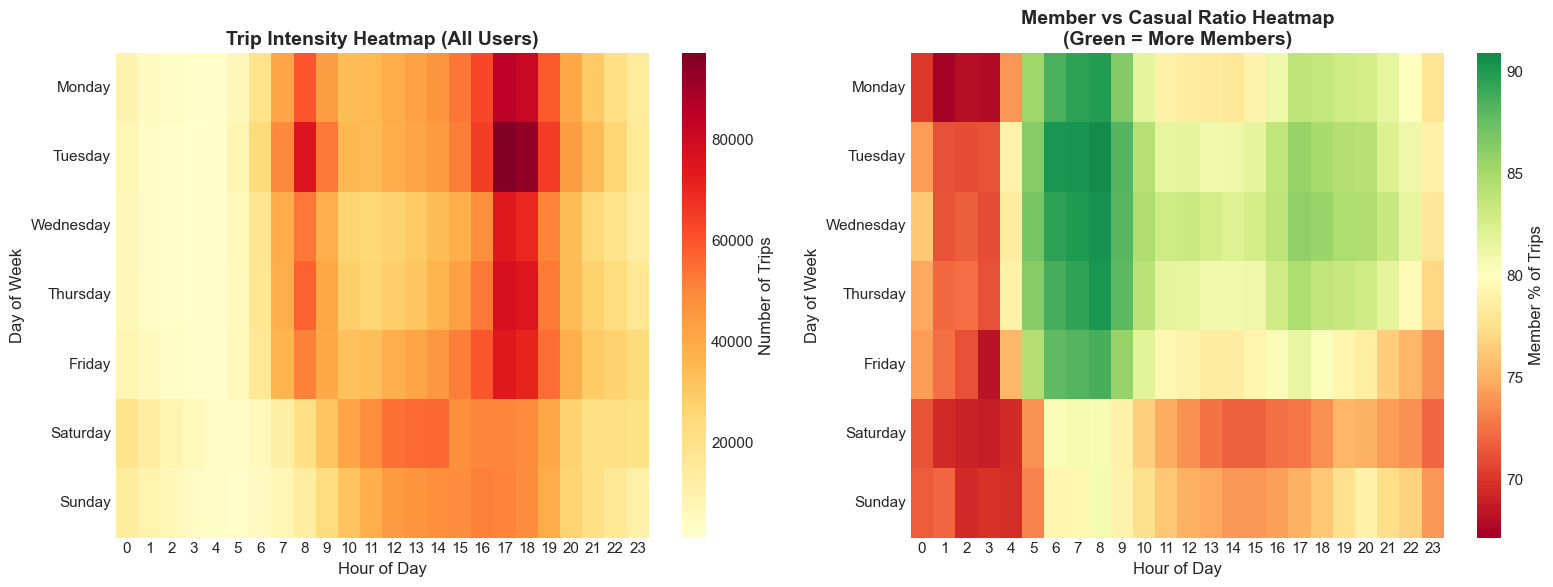

INSIGHT: Weekday mornings and evenings are dominated by members (commuters).
Weekend afternoons see higher casual user proportion (leisure trips).


In [12]:
# Heatmap: Hour x Day of Week
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All users heatmap
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = df.groupby(['day_num', 'hour']).size().unstack(fill_value=0)
heatmap_data.index = day_order

ax1 = axes[0]
sns.heatmap(heatmap_data, cmap='YlOrRd', ax=ax1, cbar_kws={'label': 'Number of Trips'})
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Day of Week')
ax1.set_title('Trip Intensity Heatmap (All Users)')

# Member vs Casual comparison
ax2 = axes[1]
member_pct = df.groupby(['day_num', 'hour']).apply(
    lambda x: (x['member_casual'] == 'member').mean() * 100
).unstack(fill_value=0)
member_pct.index = day_order

sns.heatmap(member_pct, cmap='RdYlGn', ax=ax2, center=80, 
            cbar_kws={'label': 'Member % of Trips'})
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Day of Week')
ax2.set_title('Member vs Casual Ratio Heatmap\n(Green = More Members)')

plt.tight_layout()
plt.show()

print("INSIGHT: Weekday mornings and evenings are dominated by members (commuters).")
print("Weekend afternoons see higher casual user proportion (leisure trips).")

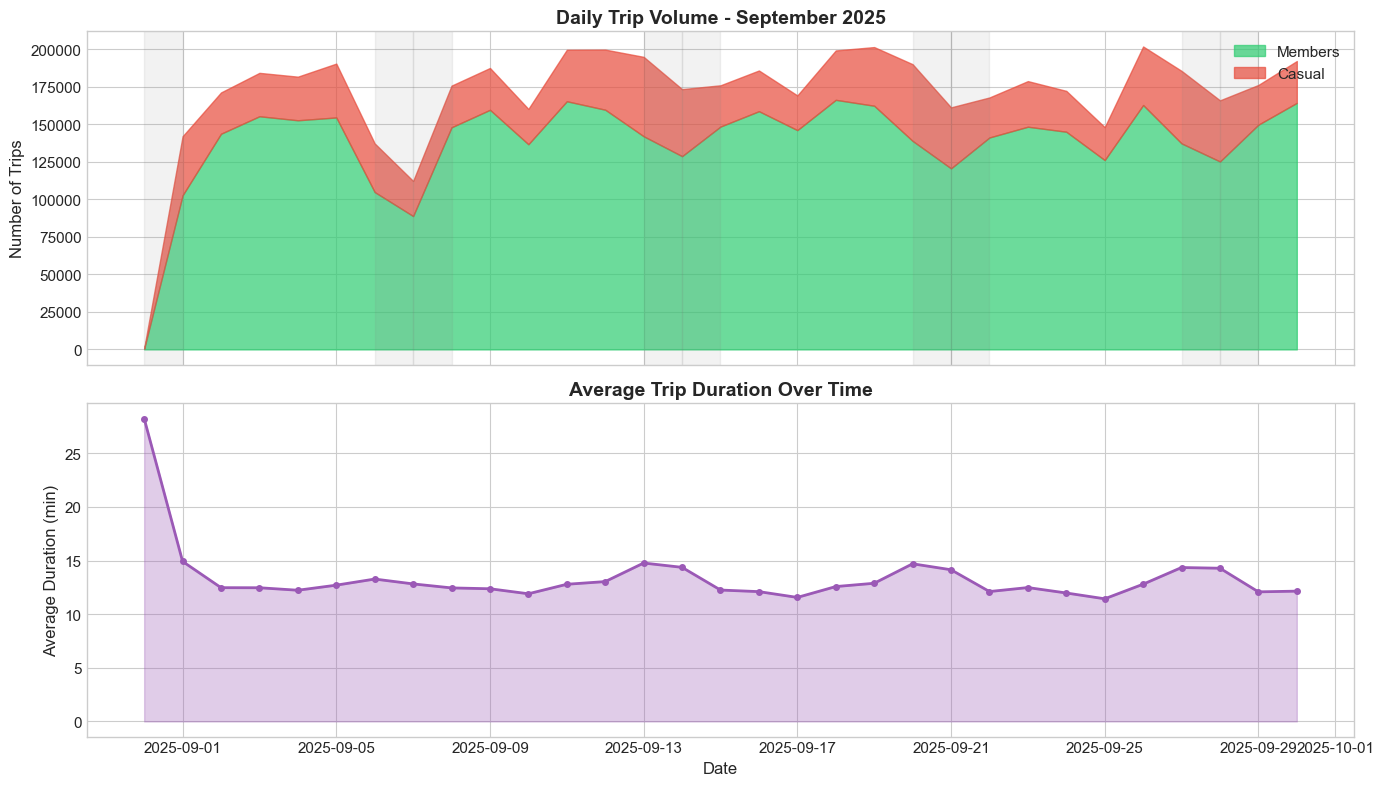


DAILY STATISTICS
Average daily trips: 170,385
Peak day: 2025-09-26 with 201,803 trips
Lowest day: 2025-08-31 with 830 trips


In [13]:
# Daily trend over the month
daily_trips = df.groupby('date').agg(
    total=('ride_id', 'count'),
    members=('member_casual', lambda x: (x == 'member').sum()),
    casuals=('member_casual', lambda x: (x == 'casual').sum()),
    avg_duration=('duration_min', 'mean')
)

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Trip volume
ax1 = axes[0]
ax1.fill_between(daily_trips.index, daily_trips['members'], label='Members', 
                 alpha=0.7, color=COLORS['member'])
ax1.fill_between(daily_trips.index, daily_trips['members'], 
                 daily_trips['members'] + daily_trips['casuals'], 
                 label='Casual', alpha=0.7, color=COLORS['casual'])
ax1.set_ylabel('Number of Trips')
ax1.set_title('Daily Trip Volume - September 2025')
ax1.legend(loc='upper right')

# Mark weekends
import datetime
for date in daily_trips.index:
    if datetime.date.fromisoformat(str(date)).weekday() >= 5:
        ax1.axvspan(date, date + datetime.timedelta(days=1), alpha=0.1, color='gray')

# Average duration
ax2 = axes[1]
ax2.plot(daily_trips.index, daily_trips['avg_duration'], 
         color=COLORS['highlight'], linewidth=2, marker='o', markersize=4)
ax2.fill_between(daily_trips.index, daily_trips['avg_duration'], alpha=0.3, color=COLORS['highlight'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Duration (min)')
ax2.set_title('Average Trip Duration Over Time')

plt.tight_layout()
plt.show()

print(f"\nDAILY STATISTICS")
print(f"Average daily trips: {daily_trips['total'].mean():,.0f}")
print(f"Peak day: {daily_trips['total'].idxmax()} with {daily_trips['total'].max():,} trips")
print(f"Lowest day: {daily_trips['total'].idxmin()} with {daily_trips['total'].min():,} trips")

---
## 6. User Segmentation Analysis

Understanding the behavioral differences between **members** (subscribers) and **casual** users (single-ride or day pass) is crucial for:
- Marketing conversion strategies
- Pricing optimization
- Service differentiation

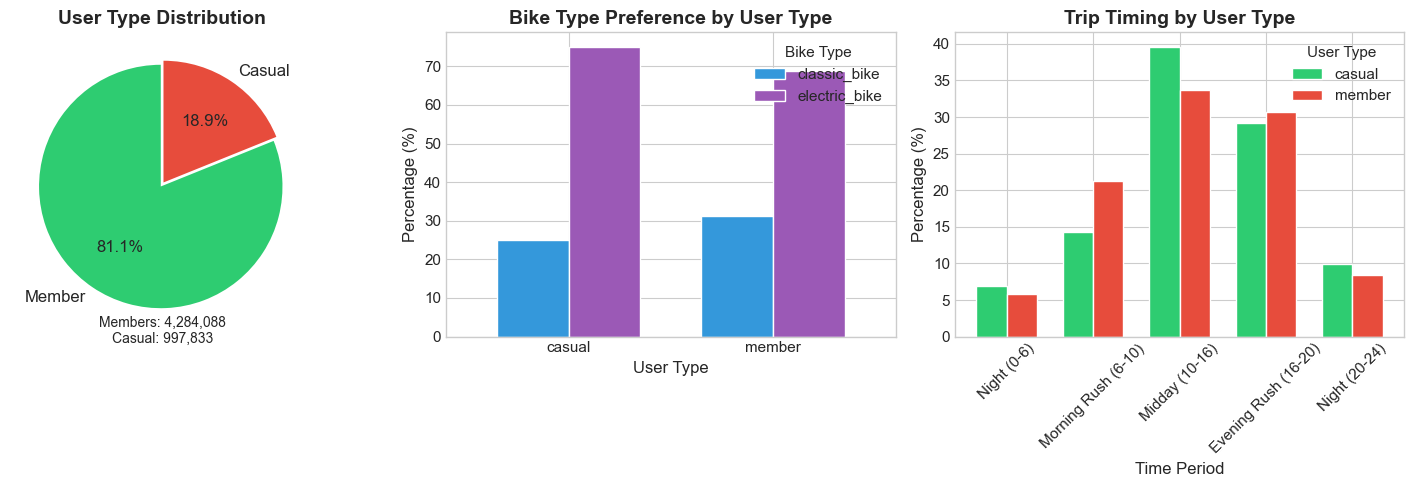

In [14]:
# User type distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Pie chart
ax1 = axes[0]
user_counts = df['member_casual'].value_counts()
explode = (0.02, 0.02)
colors = [COLORS['member'], COLORS['casual']]
wedges, texts, autotexts = ax1.pie(user_counts, labels=['Member', 'Casual'], 
                                    autopct='%1.1f%%', colors=colors, explode=explode,
                                    startangle=90, textprops={'fontsize': 12})
ax1.set_title('User Type Distribution')

# Add counts
ax1.text(0, -1.3, f"Members: {user_counts['member']:,}\nCasual: {user_counts['casual']:,}", 
         ha='center', fontsize=10)

# Bike type preference
ax2 = axes[1]
bike_user = pd.crosstab(df['member_casual'], df['rideable_type'], normalize='index') * 100
bike_user.plot(kind='bar', ax=ax2, color=['#3498db', '#9b59b6'], edgecolor='white', width=0.7)
ax2.set_xlabel('User Type')
ax2.set_ylabel('Percentage (%)')
ax2.set_title('Bike Type Preference by User Type')
ax2.tick_params(axis='x', rotation=0)
ax2.legend(title='Bike Type', loc='upper right')

# Time period preference
ax3 = axes[2]
time_user = pd.crosstab(df['time_period'], df['member_casual'], normalize='columns') * 100
time_user.plot(kind='bar', ax=ax3, color=[COLORS['member'], COLORS['casual']], 
               edgecolor='white', width=0.7)
ax3.set_xlabel('Time Period')
ax3.set_ylabel('Percentage (%)')
ax3.set_title('Trip Timing by User Type')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='User Type')

plt.tight_layout()
plt.show()

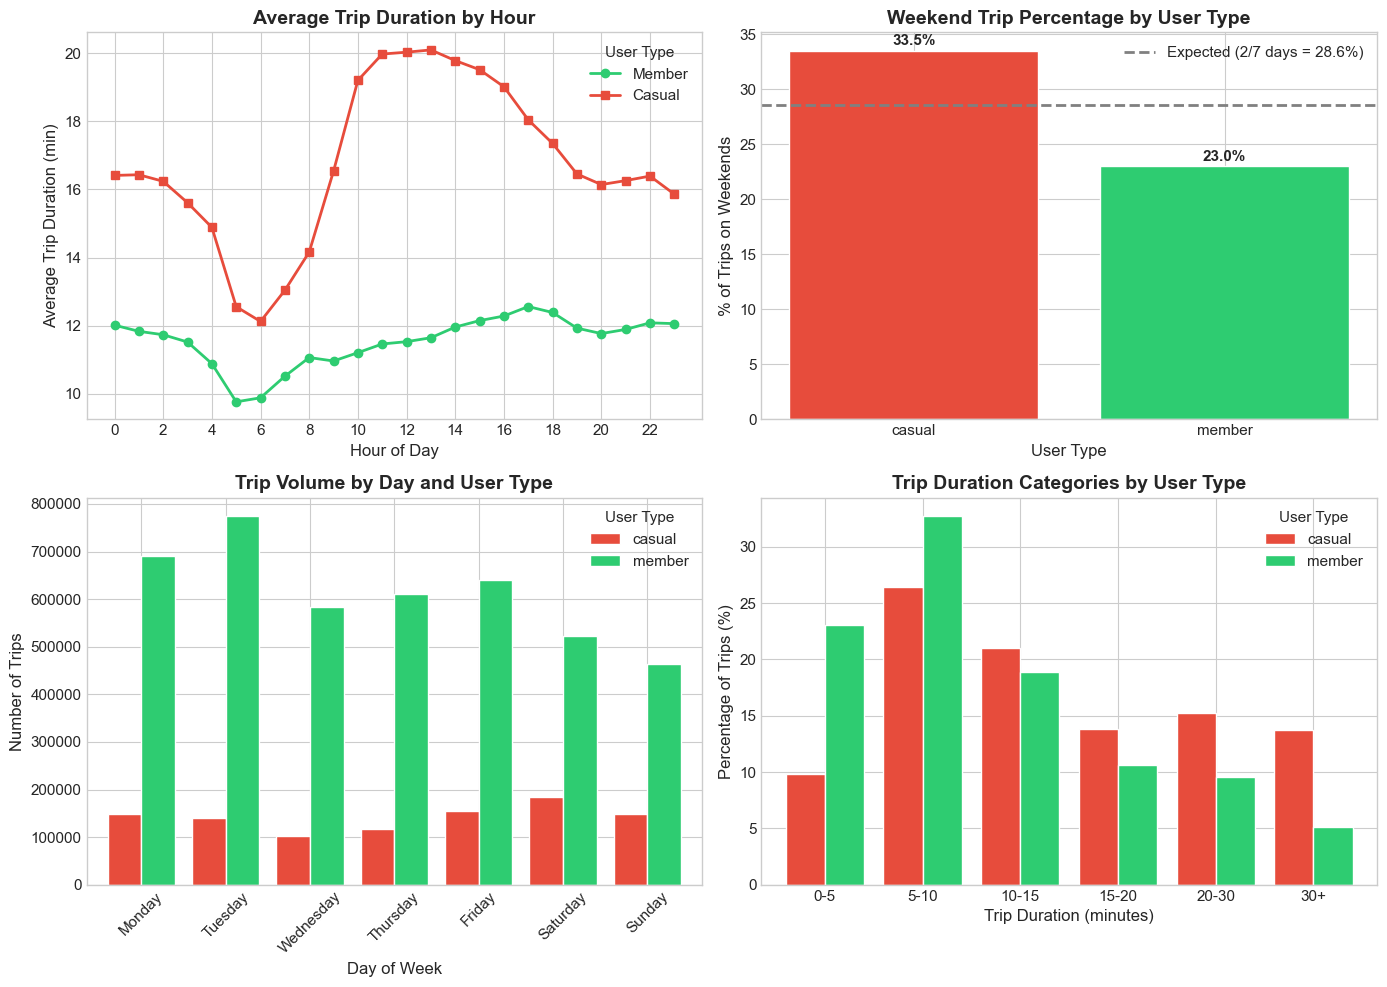


KEY DIFFERENCES:
- Members: 23.0% weekend trips (below expected - commuter pattern)
- Casual: 33.5% weekend trips (above expected - leisure pattern)


In [15]:
# Comprehensive user comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Average duration by hour
ax1 = axes[0, 0]
hourly_duration = df.groupby(['hour', 'member_casual'])['duration_min'].mean().unstack()
hourly_duration['member'].plot(ax=ax1, marker='o', linewidth=2, color=COLORS['member'], label='Member')
hourly_duration['casual'].plot(ax=ax1, marker='s', linewidth=2, color=COLORS['casual'], label='Casual')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Average Trip Duration (min)')
ax1.set_title('Average Trip Duration by Hour')
ax1.legend(title='User Type')
ax1.set_xticks(range(0, 24, 2))

# Weekend ratio
ax2 = axes[0, 1]
weekend_ratio = df.groupby('member_casual')['is_weekend'].mean() * 100
bars = ax2.bar(weekend_ratio.index, weekend_ratio.values, 
               color=[COLORS['casual'], COLORS['member']], edgecolor='white')
ax2.axhline(y=28.57, color='gray', linestyle='--', linewidth=2, label='Expected (2/7 days = 28.6%)')
ax2.set_xlabel('User Type')
ax2.set_ylabel('% of Trips on Weekends')
ax2.set_title('Weekend Trip Percentage by User Type')
ax2.legend()
for bar, val in zip(bars, weekend_ratio.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{val:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Trip count distribution by day
ax3 = axes[1, 0]
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_by_user = df.groupby(['day_of_week', 'member_casual']).size().unstack()
daily_by_user = daily_by_user.reindex(day_order)
daily_by_user.plot(kind='bar', ax=ax3, color=[COLORS['casual'], COLORS['member']], 
                   edgecolor='white', width=0.8)
ax3.set_xlabel('Day of Week')
ax3.set_ylabel('Number of Trips')
ax3.set_title('Trip Volume by Day and User Type')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='User Type')

# Duration categories
ax4 = axes[1, 1]
df['duration_category'] = pd.cut(df['duration_min'], 
                                  bins=[0, 5, 10, 15, 20, 30, 180],
                                  labels=['0-5', '5-10', '10-15', '15-20', '20-30', '30+'])
duration_cat = pd.crosstab(df['duration_category'], df['member_casual'], normalize='columns') * 100
duration_cat.plot(kind='bar', ax=ax4, color=[COLORS['casual'], COLORS['member']], 
                  edgecolor='white', width=0.8)
ax4.set_xlabel('Trip Duration (minutes)')
ax4.set_ylabel('Percentage of Trips (%)')
ax4.set_title('Trip Duration Categories by User Type')
ax4.tick_params(axis='x', rotation=0)
ax4.legend(title='User Type')

plt.tight_layout()
plt.show()

print("\nKEY DIFFERENCES:")
print(f"- Members: {weekend_ratio['member']:.1f}% weekend trips (below expected - commuter pattern)")
print(f"- Casual: {weekend_ratio['casual']:.1f}% weekend trips (above expected - leisure pattern)")

---
## 7. Station Demand Analysis

Identifying high-demand stations is critical for:
- **Capacity planning**: Dock expansion decisions
- **Rebalancing operations**: Truck route optimization
- **Marketing**: Targeted promotions at high-traffic locations

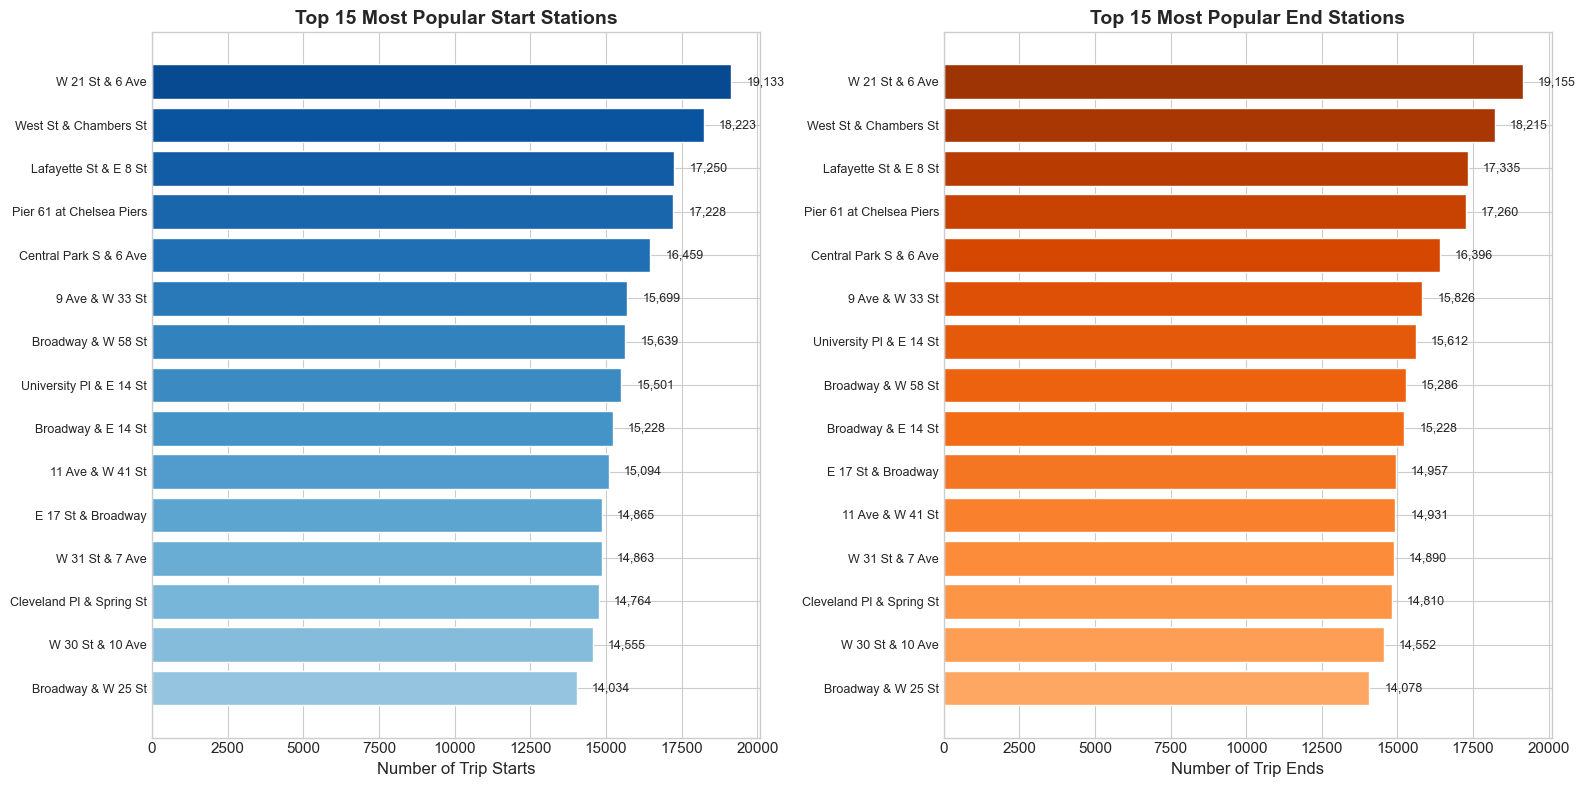

In [16]:
# Top stations analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 start stations
ax1 = axes[0]
top_start = df['start_station_name'].value_counts().head(15)
colors = plt.cm.Blues(np.linspace(0.4, 0.9, 15))[::-1]
bars = ax1.barh(range(len(top_start)), top_start.values, color=colors, edgecolor='white')
ax1.set_yticks(range(len(top_start)))
ax1.set_yticklabels(top_start.index, fontsize=9)
ax1.set_xlabel('Number of Trip Starts')
ax1.set_title('Top 15 Most Popular Start Stations', fontweight='bold')
ax1.invert_yaxis()

for bar, val in zip(bars, top_start.values):
    ax1.text(val + 500, bar.get_y() + bar.get_height()/2, f'{val:,}', 
             va='center', fontsize=9)

# Top 15 end stations
ax2 = axes[1]
top_end = df['end_station_name'].value_counts().head(15)
colors = plt.cm.Oranges(np.linspace(0.4, 0.9, 15))[::-1]
bars = ax2.barh(range(len(top_end)), top_end.values, color=colors, edgecolor='white')
ax2.set_yticks(range(len(top_end)))
ax2.set_yticklabels(top_end.index, fontsize=9)
ax2.set_xlabel('Number of Trip Ends')
ax2.set_title('Top 15 Most Popular End Stations', fontweight='bold')
ax2.invert_yaxis()

for bar, val in zip(bars, top_end.values):
    ax2.text(val + 500, bar.get_y() + bar.get_height()/2, f'{val:,}', 
             va='center', fontsize=9)

plt.tight_layout()
plt.show()

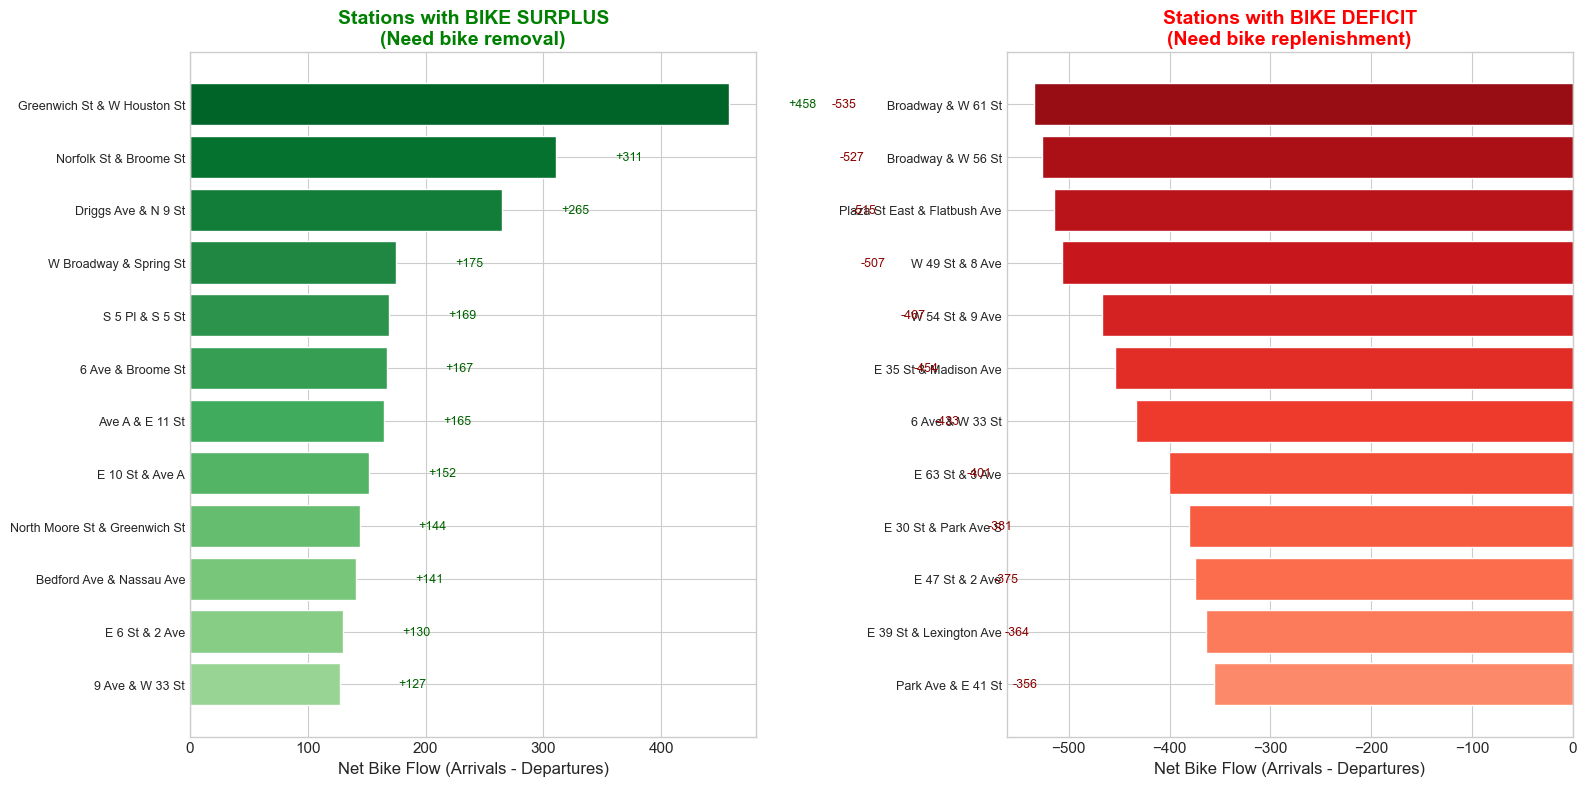


OPERATIONAL INSIGHT:
Total stations analyzed: 379 (high-volume only)
Max surplus: 458 bikes at Greenwich St & W Houston St
Max deficit: -535 bikes at Broadway & W 61 St


In [17]:
# Station imbalance analysis (critical for operations)
departures = df['start_station_name'].value_counts()
arrivals = df['end_station_name'].value_counts()

flow = pd.DataFrame({
    'departures': departures,
    'arrivals': arrivals
}).fillna(0)
flow['net_flow'] = flow['arrivals'] - flow['departures']
flow['total_trips'] = flow['arrivals'] + flow['departures']
flow['imbalance_pct'] = (flow['net_flow'] / flow['total_trips'] * 100).round(1)

# Filter to high-volume stations
flow_significant = flow[flow['total_trips'] > 10000]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Stations with surplus (bikes accumulate - need removal)
ax1 = axes[0]
top_surplus = flow_significant.nlargest(12, 'net_flow')
colors = plt.cm.Greens(np.linspace(0.4, 0.9, 12))[::-1]
bars = ax1.barh(range(len(top_surplus)), top_surplus['net_flow'].values, 
                color=colors, edgecolor='white')
ax1.set_yticks(range(len(top_surplus)))
ax1.set_yticklabels(top_surplus.index, fontsize=9)
ax1.set_xlabel('Net Bike Flow (Arrivals - Departures)')
ax1.set_title('Stations with BIKE SURPLUS\n(Need bike removal)', fontweight='bold', color='green')
ax1.invert_yaxis()

for bar, val in zip(bars, top_surplus['net_flow'].values):
    ax1.text(val + 50, bar.get_y() + bar.get_height()/2, f'+{int(val):,}', 
             va='center', fontsize=9, color='darkgreen')

# Stations with deficit (bikes leave - need replenishment)
ax2 = axes[1]
top_deficit = flow_significant.nsmallest(12, 'net_flow')
colors = plt.cm.Reds(np.linspace(0.4, 0.9, 12))[::-1]
bars = ax2.barh(range(len(top_deficit)), top_deficit['net_flow'].values, 
                color=colors, edgecolor='white')
ax2.set_yticks(range(len(top_deficit)))
ax2.set_yticklabels(top_deficit.index, fontsize=9)
ax2.set_xlabel('Net Bike Flow (Arrivals - Departures)')
ax2.set_title('Stations with BIKE DEFICIT\n(Need bike replenishment)', fontweight='bold', color='red')
ax2.invert_yaxis()

for bar, val in zip(bars, top_deficit['net_flow'].values):
    ax2.text(val - 200, bar.get_y() + bar.get_height()/2, f'{int(val):,}', 
             va='center', fontsize=9, color='darkred')

plt.tight_layout()
plt.show()

print("\nOPERATIONAL INSIGHT:")
print(f"Total stations analyzed: {len(flow_significant):,} (high-volume only)")
print(f"Max surplus: {flow_significant['net_flow'].max():,.0f} bikes at {flow_significant['net_flow'].idxmax()}")
print(f"Max deficit: {flow_significant['net_flow'].min():,.0f} bikes at {flow_significant['net_flow'].idxmin()}")

---
## 8. Geographic Analysis

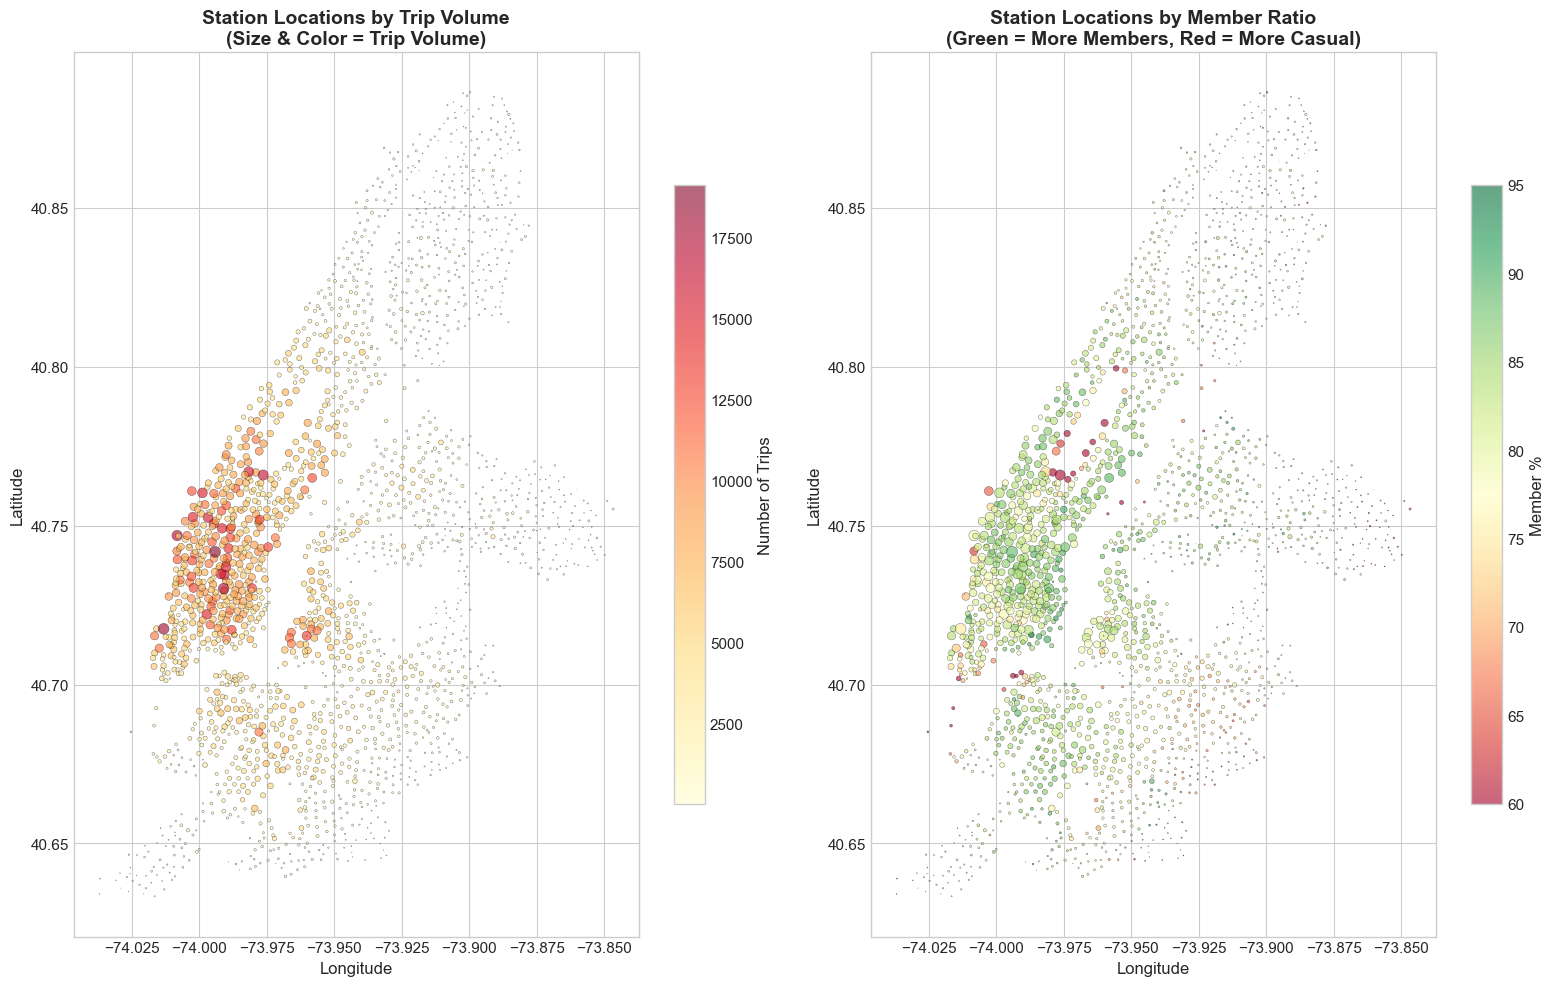


GEOGRAPHIC INSIGHTS:
- Highest volume concentrated in Midtown and Downtown Manhattan
- Tourist areas (Central Park, waterfront) show higher casual user ratios
- Commuter corridors show higher member ratios


In [18]:
# Station geographic distribution
station_stats = df.groupby(['start_station_name', 'start_lat', 'start_lng']).agg({
    'ride_id': 'count',
    'duration_min': 'mean',
    'member_casual': lambda x: (x == 'member').mean() * 100
}).reset_index()
station_stats.columns = ['station', 'lat', 'lng', 'trips', 'avg_duration', 'member_pct']
station_stats = station_stats.dropna()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Trip volume map
ax1 = axes[0]
scatter1 = ax1.scatter(
    station_stats['lng'], station_stats['lat'],
    c=station_stats['trips'],
    s=station_stats['trips'] / 300,
    cmap='YlOrRd',
    alpha=0.6,
    edgecolors='black',
    linewidths=0.3
)
plt.colorbar(scatter1, ax=ax1, label='Number of Trips', shrink=0.7)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Station Locations by Trip Volume\n(Size & Color = Trip Volume)', fontweight='bold')

# Member percentage map
ax2 = axes[1]
scatter2 = ax2.scatter(
    station_stats['lng'], station_stats['lat'],
    c=station_stats['member_pct'],
    s=station_stats['trips'] / 300,
    cmap='RdYlGn',
    alpha=0.6,
    edgecolors='black',
    linewidths=0.3,
    vmin=60, vmax=95
)
plt.colorbar(scatter2, ax=ax2, label='Member %', shrink=0.7)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Station Locations by Member Ratio\n(Green = More Members, Red = More Casual)', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nGEOGRAPHIC INSIGHTS:")
print("- Highest volume concentrated in Midtown and Downtown Manhattan")
print("- Tourist areas (Central Park, waterfront) show higher casual user ratios")
print("- Commuter corridors show higher member ratios")

---
## 9. Summary & Key Findings

In [19]:
# Executive summary statistics
print("="*60)
print("            CITIBIKE NYC - EXECUTIVE SUMMARY")
print("="*60)
print(f"\n{'DATASET OVERVIEW':-^60}")
print(f"  Total Trips Analyzed:     {len(df):>15,}")
print(f"  Date Range:               {str(df['date'].min())} to {str(df['date'].max())}")
print(f"  Unique Stations:          {df['start_station_name'].nunique():>15,}")

print(f"\n{'TRIP CHARACTERISTICS':-^60}")
print(f"  Average Duration:         {df['duration_min'].mean():>15.1f} min")
print(f"  Median Duration:          {df['duration_min'].median():>15.1f} min")
print(f"  Peak Hour:                {df.groupby('hour').size().idxmax():>15}:00")
print(f"  Busiest Day:              {df['day_of_week'].value_counts().index[0]:>15}")

print(f"\n{'USER SEGMENTATION':-^60}")
member_pct = (df['member_casual'] == 'member').mean() * 100
print(f"  Member Trips:             {member_pct:>14.1f}%")
print(f"  Casual Trips:             {100-member_pct:>14.1f}%")
print(f"  Member Avg Duration:      {df[df['member_casual']=='member']['duration_min'].mean():>15.1f} min")
print(f"  Casual Avg Duration:      {df[df['member_casual']=='casual']['duration_min'].mean():>15.1f} min")

print(f"\n{'BIKE TYPES':-^60}")
bike_counts = df['rideable_type'].value_counts()
for bike_type, count in bike_counts.items():
    print(f"  {bike_type.replace('_', ' ').title()}:  {count:>20,} ({count/len(df)*100:.1f}%)")

print("\n" + "="*60)

            CITIBIKE NYC - EXECUTIVE SUMMARY

----------------------DATASET OVERVIEW----------------------
  Total Trips Analyzed:           5,281,921
  Date Range:               2025-08-31 to 2025-09-30
  Unique Stations:                    2,145

--------------------TRIP CHARACTERISTICS--------------------
  Average Duration:                    12.9 min
  Median Duration:                      9.6 min
  Peak Hour:                             17:00
  Busiest Day:                      Tuesday

---------------------USER SEGMENTATION----------------------
  Member Trips:                       81.1%
  Casual Trips:                       18.9%
  Member Avg Duration:                 11.7 min
  Casual Avg Duration:                 17.8 min

-------------------------BIKE TYPES-------------------------
  Electric Bike:             3,699,950 (70.0%)
  Classic Bike:             1,581,971 (30.0%)



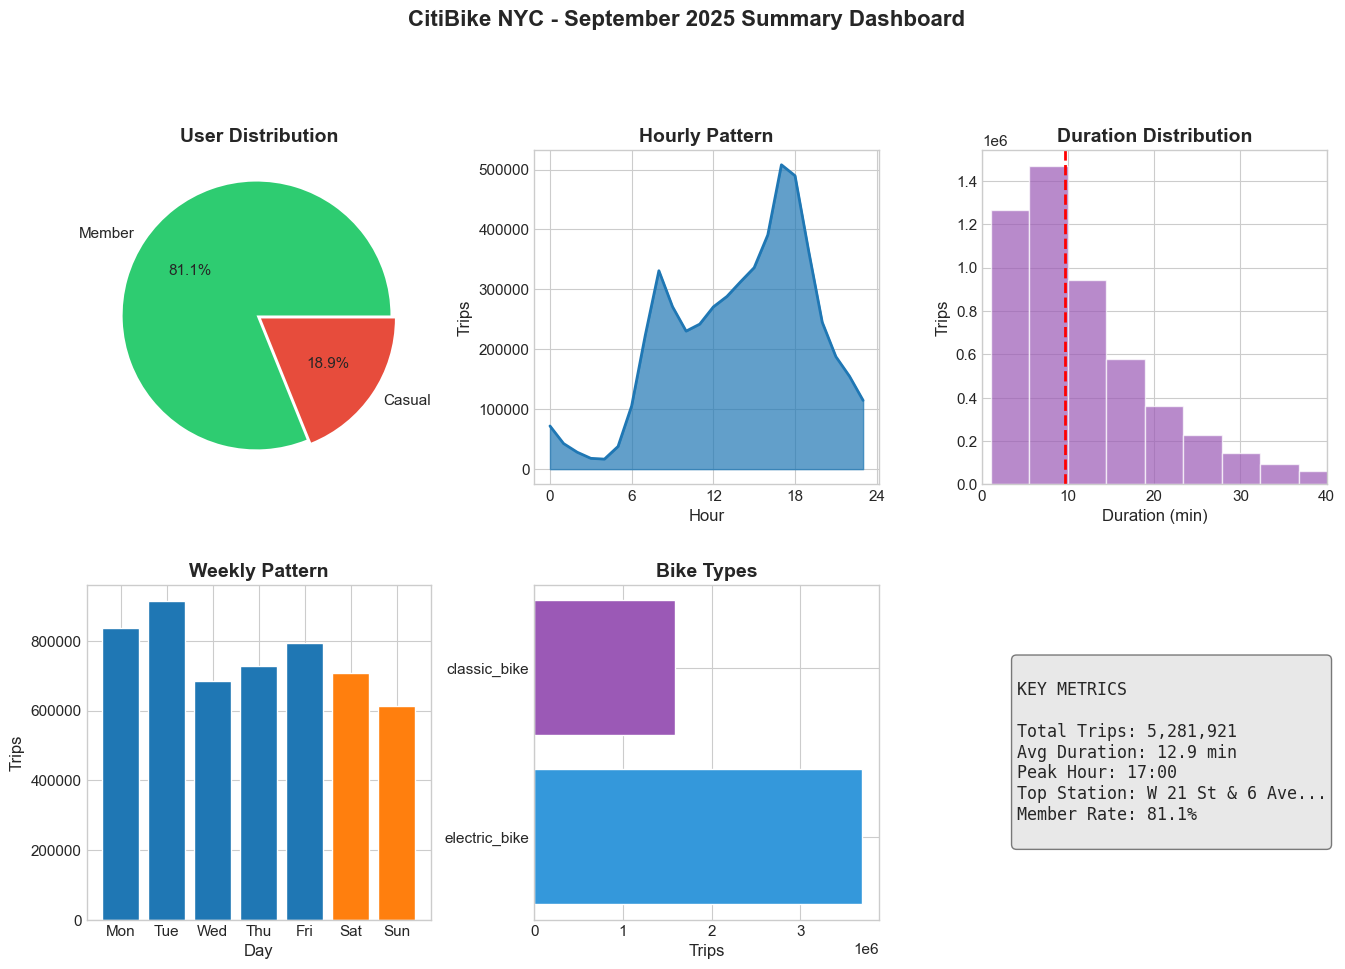

In [20]:
# Final summary visualization
fig = plt.figure(figsize=(16, 10))

# Create a summary dashboard
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. User distribution
ax1 = fig.add_subplot(gs[0, 0])
user_counts = df['member_casual'].value_counts()
ax1.pie(user_counts, labels=['Member', 'Casual'], autopct='%1.1f%%',
        colors=[COLORS['member'], COLORS['casual']], explode=(0.02, 0.02))
ax1.set_title('User Distribution', fontweight='bold')

# 2. Hourly pattern
ax2 = fig.add_subplot(gs[0, 1])
hourly = df.groupby('hour').size()
ax2.fill_between(hourly.index, hourly.values, alpha=0.7, color=COLORS['primary'])
ax2.plot(hourly.index, hourly.values, color=COLORS['primary'], linewidth=2)
ax2.set_xlabel('Hour')
ax2.set_ylabel('Trips')
ax2.set_title('Hourly Pattern', fontweight='bold')
ax2.set_xticks([0, 6, 12, 18, 24])

# 3. Duration distribution
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(df['duration_min'], bins=40, color=COLORS['highlight'], alpha=0.7, edgecolor='white')
ax3.axvline(df['duration_min'].median(), color='red', linestyle='--', linewidth=2)
ax3.set_xlim(0, 40)
ax3.set_xlabel('Duration (min)')
ax3.set_ylabel('Trips')
ax3.set_title('Duration Distribution', fontweight='bold')

# 4. Weekly pattern
ax4 = fig.add_subplot(gs[1, 0])
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily = df.groupby('day_num').size()
colors = [COLORS['primary'] if d < 5 else COLORS['secondary'] for d in range(7)]
ax4.bar(day_order, daily.values, color=colors, edgecolor='white')
ax4.set_xlabel('Day')
ax4.set_ylabel('Trips')
ax4.set_title('Weekly Pattern', fontweight='bold')

# 5. Bike types
ax5 = fig.add_subplot(gs[1, 1])
bike_counts = df['rideable_type'].value_counts()
ax5.barh(bike_counts.index, bike_counts.values, color=['#3498db', '#9b59b6'], edgecolor='white')
ax5.set_xlabel('Trips')
ax5.set_title('Bike Types', fontweight='bold')

# 6. Key metrics
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')
metrics_text = f"""
KEY METRICS

Total Trips: {len(df):,}
Avg Duration: {df['duration_min'].mean():.1f} min
Peak Hour: {df.groupby('hour').size().idxmax()}:00
Top Station: {df['start_station_name'].value_counts().index[0][:25]}...
Member Rate: {(df['member_casual']=='member').mean()*100:.1f}%
"""
ax6.text(0.1, 0.5, metrics_text, transform=ax6.transAxes, fontsize=12,
         verticalalignment='center', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))

plt.suptitle('CitiBike NYC - September 2025 Summary Dashboard', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 10. Business Recommendations

| Area | Finding | Recommendation |
|------|---------|----------------|
| **Operations** | Clear morning (8-9 AM) and evening (5-6 PM) demand peaks | Pre-position bikes at high-demand stations before rush hours |
| **Rebalancing** | Significant imbalance at commuter stations | Prioritize rebalancing at Midtown stations during off-peak hours |
| **Marketing** | ~19% casual users with 40% longer trip durations | Target casual users with membership conversion campaigns |
| **Infrastructure** | Top 10 stations handle disproportionate volume | Consider capacity expansion at busiest locations |
| **Pricing** | Weekend casual usage is high | Introduce weekend membership tiers to capture leisure market |
| **Fleet** | Electric bikes show different usage patterns | Optimize e-bike distribution based on demand |

---

## About

**Author:** Miguel Ángel Vázquez Varela  
**Project:** Urban Mobility Analytics Portfolio  
**Data Source:** [CitiBike System Data](https://citibikenyc.com/system-data)  
**Tools:** Python, Pandas, Matplotlib, Seaborn

---
*Analysis completed October 2025*